## TSS mini-Projet
### Dental X-ray dataset is used for training and testing.

# Imports and Setup

In [169]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [170]:
# Installing BM3D package
!pip install bm3d

# Section 1 : Using BM3D

In [171]:
# Imports for necessary libraries and dependencies
import numpy as np
import pandas as pd
import os
import bm3d
import torch
import torchvision
import matplotlib.pyplot as plt
from keras.preprocessing import image
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.autograd import Variable
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf
import cv2


# Setting up the data path
data_path = '/content/drive/MyDrive/TSS project/Dataset/'

In [172]:
train_images = os.listdir(data_path)
train_images

['14.jpg',
 '112.jpg',
 '115.jpg',
 '17.jpg',
 '15.jpg',
 '21.jpg',
 '12.jpg',
 '11.jpg',
 '106.jpg',
 '19.jpg',
 '102.jpg',
 '108.jpg',
 '23.jpg',
 '103.jpg',
 '20.jpg',
 '107.jpg',
 '105.jpg',
 '24.jpg',
 '117.jpg',
 '113.jpg',
 '104.jpg',
 '114.jpg',
 '116.jpg',
 '13.jpg',
 '120.jpg',
 '101.jpg',
 '118.jpg',
 '16.jpg',
 '22.jpg',
 '111.jpg',
 '1.jpg',
 '2.jpg',
 '110.jpg',
 '100.jpg',
 '10.jpg',
 '119.jpg',
 '18.jpg',
 '109.jpg',
 '25.jpg',
 '8.jpg',
 '43.jpg',
 '73.jpg',
 '27.jpg',
 '87.jpg',
 '98.jpg',
 '66.jpg',
 '63.jpg',
 '94.jpg',
 '32.jpg',
 '33.jpg',
 '52.jpg',
 '26.jpg',
 '97.jpg',
 '3.jpg',
 '49.jpg',
 '67.jpg',
 '53.jpg',
 '48.jpg',
 '90.jpg',
 '93.jpg',
 '77.jpg',
 '72.jpg',
 '29.jpg',
 '61.jpg',
 '70.jpg',
 '9.jpg',
 '75.jpg',
 '50.jpg',
 '81.jpg',
 '68.jpg',
 '40.jpg',
 '35.jpg',
 '5.jpg',
 '69.jpg',
 '38.jpg',
 '60.jpg',
 '55.jpg',
 '92.jpg',
 '31.jpg',
 '62.jpg',
 '45.jpg',
 '74.jpg',
 '6.jpg',
 '4.jpg',
 '83.jpg',
 '57.jpg',
 '51.jpg',
 '99.jpg',
 '36.jpg',
 '84.jpg

### Constructing the dataset in the required format

In [173]:
train_image = []
for im in train_images:
    img = image.load_img(data_path+ im, target_size=(64,64), color_mode= 'grayscale')
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
images = np.array(train_image)


### Defining a plot function

In [174]:
def show_img(dataset):
    f, ax = plt.subplots(1,5)
    f.set_size_inches(10, 5)
    for i in range(5,10):
        ax[i-5].imshow(dataset[i].reshape(64,64), cmap='gray')
    plt.show()

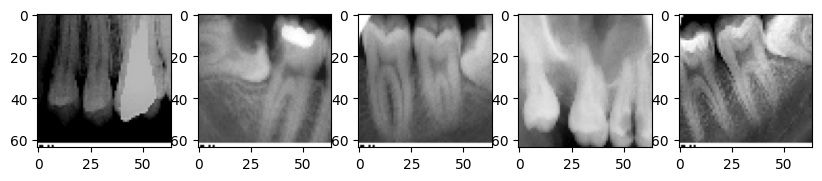

In [175]:
show_img(images)

## Exploring Diverse Noises

I focused in two types of noise:
- White Additive Noise (Gaussian) : WA
- Poisson Noise (Poisson): Poisson

In [176]:
def add_noise(images, noise_type='WA'):
    if noise_type == 'WA':
        noisy_images = (images + np.random.normal(0, 0.2, images.shape)).clip(0, 1)
        print('White Additive Noise has been added')
        return noisy_images
    if noise_type == 'Poisson':
        a = 5 * np.ones(images.shape)
        p = np.random.poisson(a)
        p_norm = p / p.max()
        poisson_noisy_images = (images + p_norm).clip(0, 1)
        print('Poisson noise has been added')
        return poisson_noisy_images




**White Additive Noise :**

In [177]:
noisy_images = add_noise(images,'WA')

White Additive Noise has been added


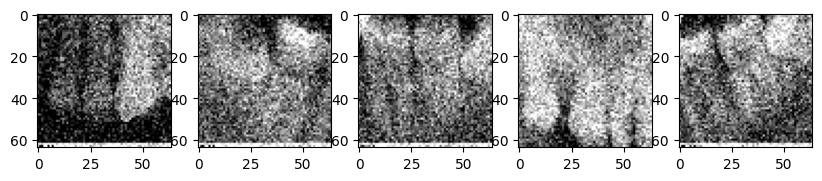

In [178]:
show_img(noisy_images)

**Poisson Noise :**

In [179]:
poisson_noisy_images = add_noise(images,'Poisson')

Poisson noise has been added


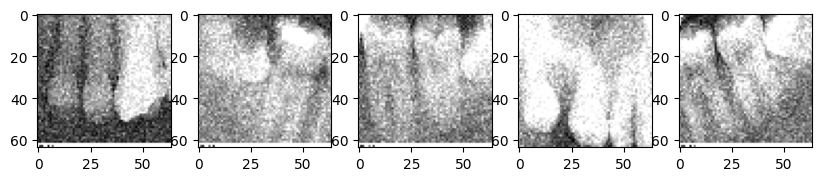

In [180]:
show_img(poisson_noisy_images)

**These are some helper functions to evaluate the the performance of the denoising approachs: PSNR/SSIM**

In [181]:
from math import log10, sqrt
def PSNR(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return 100
    max_pixel = 255.0
    return 20 * log10(max_pixel / sqrt(mse))


In [182]:
def display_image_with_psnr(original, noisy, psnr1,psnr2=0, denoised=None, denoised_exist=False):
    plt.figure(figsize=(7, 1.5))

    # Original Image
    plt.subplot(151)
    plt.imshow(original, cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Noisy Image
    plt.subplot(152)
    plt.imshow(noisy, cmap='gray')
    plt.title('Noisy \nImage')
    plt.axis('off')

    # PSNR Value and Denoised Image (if available)
    if denoised_exist:
        plt.subplot(153)
        plt.imshow(denoised, cmap='gray')
        plt.title('Denoised \nImage')
        plt.axis('off')

        plt.subplot(154)
        plt.text(0.5, 0.5, f'PSNR: {psnr1:.2f} dB', ha='center', va='center', fontsize=12)
        plt.title('PSNR value\nbefore Denoising')
        plt.axis('off')

        plt.subplot(155)
        plt.text(0.5, 0.5, f'PSNR: {psnr2:.2f} dB', ha='center', va='center', fontsize=12)
        plt.title('PSNR value\nafter Denoising')
        plt.axis('off')
    else:
        plt.subplot(153)
        plt.text(0.5, 0.5, f'PSNR: {psnr1:.2f} dB', ha='center', va='center', fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [183]:
def display_image_with_ssim(original, noisy, ssim1, ssim2=0, denoised=None, denoised_exist=False):
    plt.figure(figsize=(7, 1.5))

    # Original Image
    plt.subplot(151)
    plt.imshow(original, cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Noisy Image
    plt.subplot(152)
    plt.imshow(noisy, cmap='gray')
    plt.title('Noisy \nImage')
    plt.axis('off')

    # SSIM Value and Denoised Image (if available)
    if denoised_exist:
        plt.subplot(153)
        plt.imshow(denoised, cmap='gray')
        plt.title('Denoised \nImage')
        plt.axis('off')

        plt.subplot(154)
        plt.text(0.5, 0.5, f'SSIM: {ssim1:.4f}', ha='center', va='center', fontsize=12)
        plt.title('SSIM value\nbefore Denoising')
        plt.axis('off')

        plt.subplot(155)
        plt.text(0.5, 0.5, f'SSIM: {ssim2:.4f}', ha='center', va='center', fontsize=12)
        plt.title('SSIM value\nafter Denoising')
        plt.axis('off')
    else:
        plt.subplot(153)
        plt.text(0.5, 0.5, f'SSIM: {ssim1:.4f}', ha='center', va='center', fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [184]:
def Result_PSNR(i):
    original_image = images[i].reshape(64, 64)
    noisy_image = noisy_images[i].reshape(64, 64)
    poisson_image = poisson_noisy_images[i].reshape(64, 64)

    # Display and calculate PSNR for each noise type
    print("##### White Additive Noise Images ##### ")
    psnr_normal = PSNR(original_image, noisy_image)
    display_image_with_psnr(original_image, noisy_image,psnr1=psnr_normal)

    print("##### Poisson Noise Images #####")
    psnr_poisson = PSNR(original_image, poisson_image)
    display_image_with_psnr(original_image, poisson_image,psnr1= psnr_poisson)

##### White Additive Noise Images ##### 


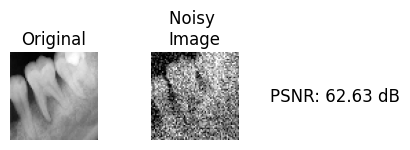

##### Poisson Noise Images #####


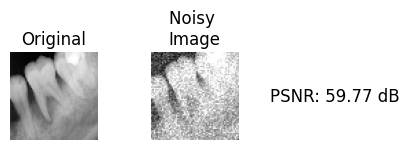

In [185]:
# I choosed the images with the index = 20 (just an example of usage)
Result_PSNR(20)

## Denoising using BM3D

In [186]:
def Result_denoising_using_BM3D(i):
    print('###### Result of denoising using BM3D ######')
    original_image = images[i].reshape(64, 64)
    noisy_image = noisy_images[i].reshape(64, 64)
    poisson_image = poisson_noisy_images[i].reshape(64, 64)

    # Display and calculate PSNR for each noise type
    print("\tWhite Additive Noise Images")
    denoised_image = bm3d.bm3d(noisy_images[i], sigma_psd=0.2, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
    psnr_normal1 = PSNR(original_image, noisy_image)
    psnr_normal2 = PSNR(original_image, denoised_image)
    display_image_with_psnr(original_image, noisy_image, psnr_normal1,psnr_normal2,denoised_image, denoised_exist=True)

    print("\tPoisson Noise Images")
    poisson_denoised_image = bm3d.bm3d(poisson_noisy_images[i], sigma_psd=0.2, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
    psnr_poisson1 = PSNR(original_image, poisson_image)
    psnr_poisson2 = PSNR(original_image, poisson_denoised_image)
    display_image_with_psnr(original_image, poisson_image, psnr_poisson1,psnr_poisson2,poisson_denoised_image, denoised_exist=True)


In [187]:
def Result_denoising_using_BM3D_with_SSIM(i):
    print('###### Result of denoising using BM3D ######')
    original_image = images[i].reshape(64, 64)
    noisy_image = noisy_images[i].reshape(64, 64)
    poisson_image = poisson_noisy_images[i].reshape(64, 64)

    # Display and calculate SSIM for each noise type
    print("\tWhite Additive Noise Images")
    denoised_image = bm3d.bm3d(noisy_images[i], sigma_psd=0.2, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
    ssim_normal1 = ssim(original_image, noisy_image)  # Calculate SSIM using original function
    ssim_normal2 = ssim(original_image, denoised_image)
    display_image_with_ssim(original_image, noisy_image, ssim_normal1, ssim_normal2, denoised_image, denoised_exist=True)

    print("\tPoisson Noise Images")
    poisson_denoised_image = bm3d.bm3d(poisson_noisy_images[i], sigma_psd=0.2, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
    ssim_poisson1 = ssim(original_image, poisson_image)
    ssim_poisson2 = ssim(original_image, poisson_denoised_image)
    display_image_with_ssim(original_image, poisson_image, ssim_poisson1, ssim_poisson2, poisson_denoised_image, denoised_exist=True)

In [188]:
def display_image(original, noisy, denoised=None):
    plt.figure(figsize=(2.5, 2.5))

    # Noisy Image
    plt.subplot(121)
    plt.imshow(noisy, cmap='gray')
    plt.title('Noisy \nImage')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(denoised, cmap='gray')
    plt.title('Denoised \nImage')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [189]:
def Result_denoising(i):
    print('###### Result of denoising using BM3D ######')
    original_image = images[i].reshape(64, 64)
    noisy_image = noisy_images[i].reshape(64, 64)
    poisson_image = poisson_noisy_images[i].reshape(64, 64)

    # Display and calculate SSIM for each noise type
    print("  White Additive Noise Images")
    denoised_image = bm3d.bm3d(noisy_images[i], sigma_psd=0.2, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)

    display_image(original_image, noisy_image, denoised_image)

    print("  Poisson Noise Images")
    poisson_denoised_image = bm3d.bm3d(poisson_noisy_images[i], sigma_psd=0.2, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)

    display_image(original_image, poisson_image, poisson_denoised_image)

###### Result of denoising using BM3D ######
  White Additive Noise Images


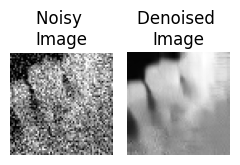

  Poisson Noise Images


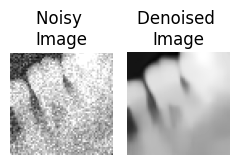

In [190]:
Result_denoising(20)

### NB
**A higher PSNR value generally indicates better image quality because it signifies a smaller difference between the original image and the altered (noisy or denoised) image.**

###### Result of denoising using BM3D ######
	White Additive Noise Images


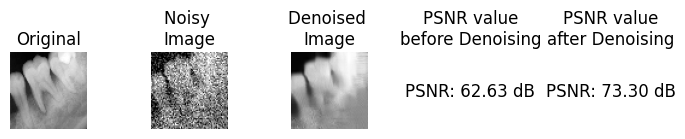

	Poisson Noise Images


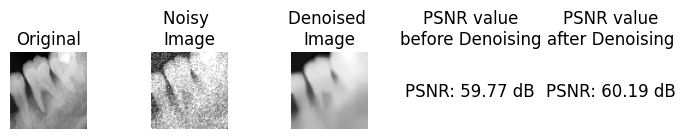

In [191]:
Result_denoising_using_BM3D(20)

**The BM3D method has given a significant improvement when used for the normal noise, but for the other two noises it wasn't as remarkable.**


###### Result of denoising using BM3D ######
	White Additive Noise Images


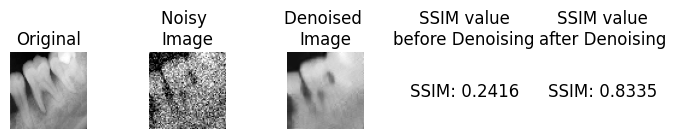

	Poisson Noise Images


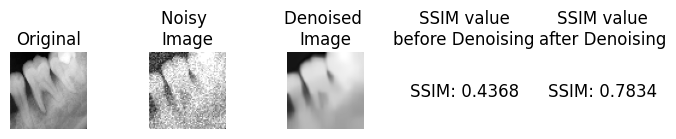

In [202]:
Result_denoising_using_BM3D_with_SSIM(20)

# Section 2 : using DeepLearning (Autoencoder)

## Choosing Data

The idea is to combine all the noisy types in one data and multplying the original data to get similar size


In [193]:
clean_images=images
noisy_images=add_noise(images,'WA')


White Additive Noise has been added


I choose to put 80% for train ,10% for test and 10% for validation

In [194]:
train_size,val_size,test_size = int(0.8 * len(clean_images)),int(0.1 * len(clean_images)),int(0.1 * len(clean_images))

train_clean, val_clean, test_clean = clean_images[:train_size], clean_images[train_size:train_size + val_size], clean_images[train_size + val_size:]
train_noisy, val_noisy, test_noisy = noisy_images[:train_size], noisy_images[train_size:train_size + val_size], noisy_images[train_size + val_size:]


## Denoising using Deep Learning
### Defining the model architecture

In [195]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

def autoencoder():
    input_img = Input(shape=(64,64,1))

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2, 2), padding='same', name='pool1')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2, 2), padding='same', name='pool2')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2, 2), name='upsample1')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2, 2), name='upsample2')(x)
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='Conv5')(x)

    # Model compilation
    autoencoder = tf.keras.models.Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                        loss='mean_squared_error',
                        metrics=['mean_absolute_error'])
    return autoencoder


In [196]:
model= autoencoder()
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 Conv1 (Conv2D)              (None, 64, 64, 32)        320       
                                                                 
 pool1 (MaxPooling2D)        (None, 32, 32, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 16, 16, 64)        0         
                                                                 
 Conv3 (Conv2D)              (None, 16, 16, 64)        36928     
                                                                 
 upsample1 (UpSampling2D)    (None, 32, 32, 64)        0   

In [197]:
EPOCHS = 40
BATCH_SIZE = 128
VALIDATION = (val_noisy, val_clean)

history = model.fit(train_noisy, train_clean, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=VALIDATION)

Epoch 1/40
1/1 [==============================] - 5s 5s/step - loss: 0.0613 - mean_absolute_error: 0.1976 - val_loss: 0.0672 - val_mean_absolute_error: 0.2115
Epoch 2/40
1/1 [==============================] - 2s 2s/step - loss: 0.0594 - mean_absolute_error: 0.1949 - val_loss: 0.0654 - val_mean_absolute_error: 0.2080
Epoch 3/40
1/1 [==============================] - 2s 2s/step - loss: 0.0573 - mean_absolute_error: 0.1908 - val_loss: 0.0639 - val_mean_absolute_error: 0.2046
Epoch 4/40
1/1 [==============================] - 3s 3s/step - loss: 0.0554 - mean_absolute_error: 0.1868 - val_loss: 0.0595 - val_mean_absolute_error: 0.1972
Epoch 5/40
1/1 [==============================] - 3s 3s/step - loss: 0.0520 - mean_absolute_error: 0.1805 - val_loss: 0.0552 - val_mean_absolute_error: 0.1896
Epoch 6/40
1/1 [==============================] - 3s 3s/step - loss: 0.0487 - mean_absolute_error: 0.1744 - val_loss: 0.0513 - val_mean_absolute_error: 0.1809
Epoch 7/40
1/1 [==============================

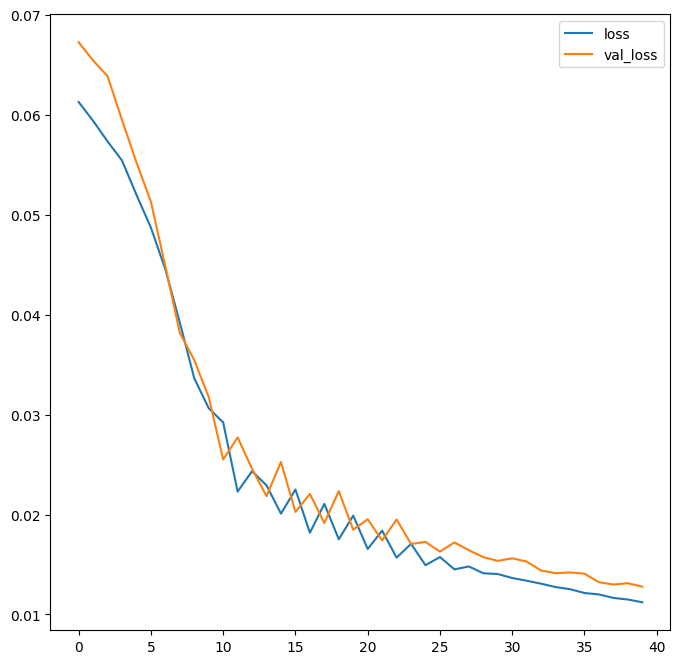

In [198]:
plt.figure(figsize = (8,8))
plt.plot( history.history['loss'], label = 'loss')
plt.plot( history.history['val_loss'], label = 'val_loss')
plt.legend(loc = 'best')
plt.show()

In [199]:
def PSNR(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return 100
    max_pixel = 255.0
    return 20 * log10(max_pixel / sqrt(mse))

**Plotting the predictions.**
- First row: Original image
- Second row: Median filter image
- Third row: Noice image
- Fourth row: Denoised image using Autoencoder

**Average PSNR is between the image and the original**

1/1 [==============================] - 0s 92ms/step


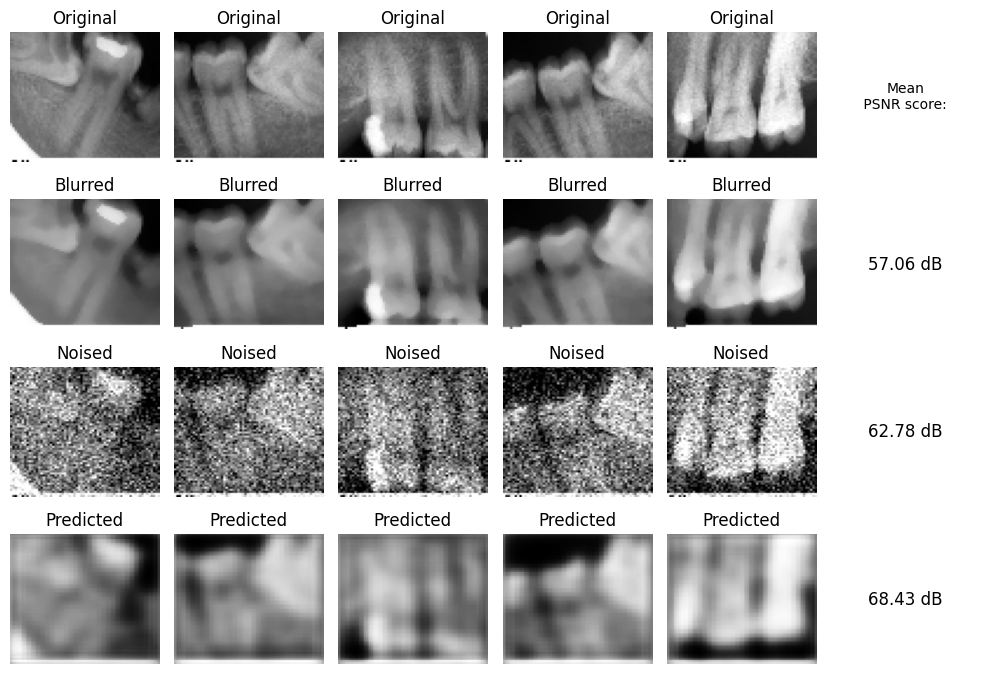

In [200]:
import cv2

pred= model.predict(test_noisy[:5])
def plot_predictions(y_true, y_pred):
    f, ax = plt.subplots(4, 6)
    image_width = int(748/5)
    image_height = int(512/5)
    aspect_ratio = image_width / image_height

    # Calculate the figure size to maintain the aspect ratio
    fig_width = 10  # Change this value as needed
    fig_height = fig_width / aspect_ratio

    f.set_size_inches(fig_width, fig_height)
    for i in range(5):

        ax[0][i].imshow(np.reshape(test_clean[i], (64,64)), aspect='auto', cmap='gray')
        ax[0][i].set_title('Original')
        ax[1][i].imshow(cv2.medianBlur(test_clean[i], (5)), aspect='auto', cmap='gray')
        ax[1][i].set_title('Blurred')
        ax[2][i].imshow(np.reshape(y_true[i], (64,64)), aspect='auto', cmap='gray')
        ax[2][i].set_title('Noised')
        ax[3][i].imshow(np.reshape(y_pred[i], (64,64)), aspect='auto', cmap='gray')
        ax[3][i].set_title('Predicted')

    psnr1=np.mean(PSNR(test_clean[:5], cv2.medianBlur(test_clean[i], (5))))
    psnr2=np.mean(PSNR(test_clean[:5], y_true[:5]))
    psnr3=np.mean(PSNR(test_clean[:5], y_pred[:5]))

    ax[0][5].text(0.5, 0.5, f'Mean\n PSNR score: ', ha='center', va='center', fontsize=10)
    ax[1][5].text(0.5, 0.5, f'{psnr1.item():.2f} dB', ha='center', va='center', fontsize=12)
    ax[2][5].text(0.5, 0.5, f'{psnr2.item():.2f} dB', ha='center', va='center', fontsize=12)
    ax[3][5].text(0.5, 0.5, f'{psnr3.item():.2f} dB', ha='center', va='center', fontsize=12)

    for row in ax:
      for col in row:
        col.axis('off')

    plt.tight_layout()
plot_predictions(test_noisy[:5], pred[:5])

Average SSIM is between the image and the original

1/1 [==============================] - 0s 49ms/step


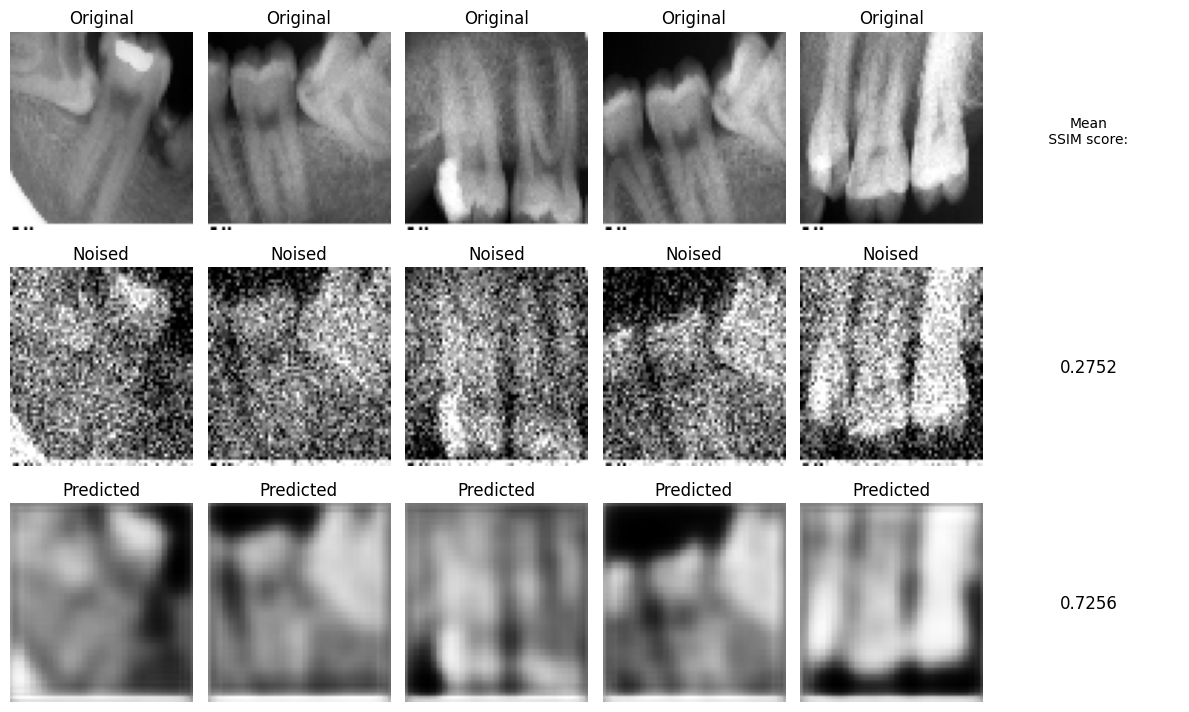

In [201]:
pred = model.predict(test_noisy[:5])

def plot_predictions_with_ssim(y_true, y_pred):
    f, ax = plt.subplots(3, 6)
    image_width = 850
    image_height = 512
    aspect_ratio = image_width / image_height

    # Calculate the figure size to maintain the aspect ratio
    fig_width = 12  # Change this value as needed
    fig_height = fig_width / aspect_ratio

    f.set_size_inches(fig_width, fig_height)
    for i in range(5):
        ax[0][i].imshow(np.reshape(test_clean[i], (64, 64)), aspect='auto', cmap='gray')
        ax[0][i].set_title('Original')
        ax[1][i].imshow(np.reshape(y_true[i], (64, 64)), aspect='auto', cmap='gray')
        ax[1][i].set_title('Noised')
        ax[2][i].imshow(np.reshape(y_pred[i], (64, 64)), aspect='auto', cmap='gray')
        ax[2][i].set_title('Predicted')

    ssim1 = np.mean([ssim(test_clean[i], y_true[i], win_size=5, channel_axis=2) for i in range(5)])
    ssim2 = np.mean([ssim(test_clean[i], y_pred[i], win_size=5, channel_axis=2) for i in range(5)])

    ax[0][5].text(0.5, 0.5, f'Mean\n SSIM score: ', ha='center', va='center', fontsize=10)
    ax[1][5].text(0.5, 0.5, f'{ssim1:.4f}', ha='center', va='center', fontsize=12)
    ax[2][5].text(0.5, 0.5, f'{ssim2:.4f}', ha='center', va='center', fontsize=12)

    for row in ax:
      for col in row:
        col.axis('off')

    plt.tight_layout()

plot_predictions_with_ssim(test_noisy[:5], pred[:5])